# *This notebook contains the code for the Coursera Capstone IBM Data Science Certificate*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_05e6e145e45a40a6868fc5018924ebc2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_05e6e145e45a40a6868fc5018924ebc2.get_object(Bucket='courseracapstone-donotdelete-pr-ksauy74m0lfpxv',Key='Data-Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
df_data.info()
# further research into the columns which have significant missing data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 37 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null obj

# Remove columns that are irrelevant

In [4]:
df_data['SPEEDING'].isnull().sum()/df_data.shape[0]
#95% of the rows in Speeding columns are NAN

0.9520580666039975

In [5]:
df_data = df_data.drop(['OBJECTID','INCKEY','LOCATION','COLDETKEY','REPORTNO','STATUS','INTKEY','EXCEPTRSNCODE',
              'EXCEPTRSNDESC','SEVERITYDESC','SDOT_COLCODE','SDOT_COLDESC','SDOTCOLNUM','ST_COLCODE',
              'ST_COLDESC','SEGLANEKEY','CROSSWALKKEY'],axis=1)


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 20 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
ADDRTYPE          192747 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
INATTENTIONIND    29805 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
PEDROWNOTGRNT     4667 non-null object
SPEEDING          9333 non-null object
HITPARKEDCAR      194673 non-null object
dtypes: float64(2), int64(5), object(13)
memory usage: 29.7+ MB


In [7]:
df_data['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

In [8]:
df_data['UNDERINFL'] = df_data['UNDERINFL'].replace(['0'], 'N')
df_data['UNDERINFL'] = df_data['UNDERINFL'].replace(['1'], 'Y')
df_data['UNDERINFL'].value_counts()


N    180668
Y      9121
Name: UNDERINFL, dtype: int64

In [9]:
# remove columns with large amount of missing data
df_data = df_data.drop(["INATTENTIONIND","PEDROWNOTGRNT",'SPEEDING'],axis=1)


In [10]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 17 columns):
SEVERITYCODE     194673 non-null int64
X                189339 non-null float64
Y                189339 non-null float64
ADDRTYPE         192747 non-null object
COLLISIONTYPE    189769 non-null object
PERSONCOUNT      194673 non-null int64
PEDCOUNT         194673 non-null int64
PEDCYLCOUNT      194673 non-null int64
VEHCOUNT         194673 non-null int64
INCDATE          194673 non-null object
INCDTTM          194673 non-null object
JUNCTIONTYPE     188344 non-null object
UNDERINFL        189789 non-null object
WEATHER          189592 non-null object
ROADCOND         189661 non-null object
LIGHTCOND        189503 non-null object
HITPARKEDCAR     194673 non-null object
dtypes: float64(2), int64(5), object(10)
memory usage: 25.2+ MB


# Check to see if there is a pattern of more accidents depending on the day of the week

In [11]:
analysis = df_data.copy()
analysis['day_of_week'] = pd.DatetimeIndex(analysis['INCDATE']).weekday_name
analysis['day_of_week'].value_counts(normalize=True)


Friday       0.166089
Thursday     0.150632
Wednesday    0.147827
Tuesday      0.146687
Saturday     0.140692
Monday       0.135294
Sunday       0.112779
Name: day_of_week, dtype: float64

# Check data for daily monthly and yearly patterns using the copy

In [12]:
analysis['month'] = pd.DatetimeIndex(analysis['INCDATE']).month
analysis['year'] = pd.DatetimeIndex(analysis['INCDATE']).year
analysis.head()

,SEVERITYCODE,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,HITPARKEDCAR,day_of_week,month,year
0,2,-122.323148,47.703140,Intersection,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 14:54,At Intersection (intersection related),N,Overcast,Wet,Daylight,N,Wednesday,3,2013
1,1,-122.347294,47.647172,Block,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 18:55,Mid-Block (not related to intersection),N,Raining,Wet,Dark - Street Lights On,N,Wednesday,12,2006
2,1,-122.334540,47.607871,Block,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20,Mid-Block (not related to intersection),N,Overcast,Dry,Daylight,N,Thursday,11,2004
3,1,-122.334803,47.604803,Block,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,N,Friday,3,2013
4,2,-122.306426,47.545739,Intersection,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04,At Intersection (intersection related),N,Raining,Wet,Daylight,N,Wednesday,1,2004


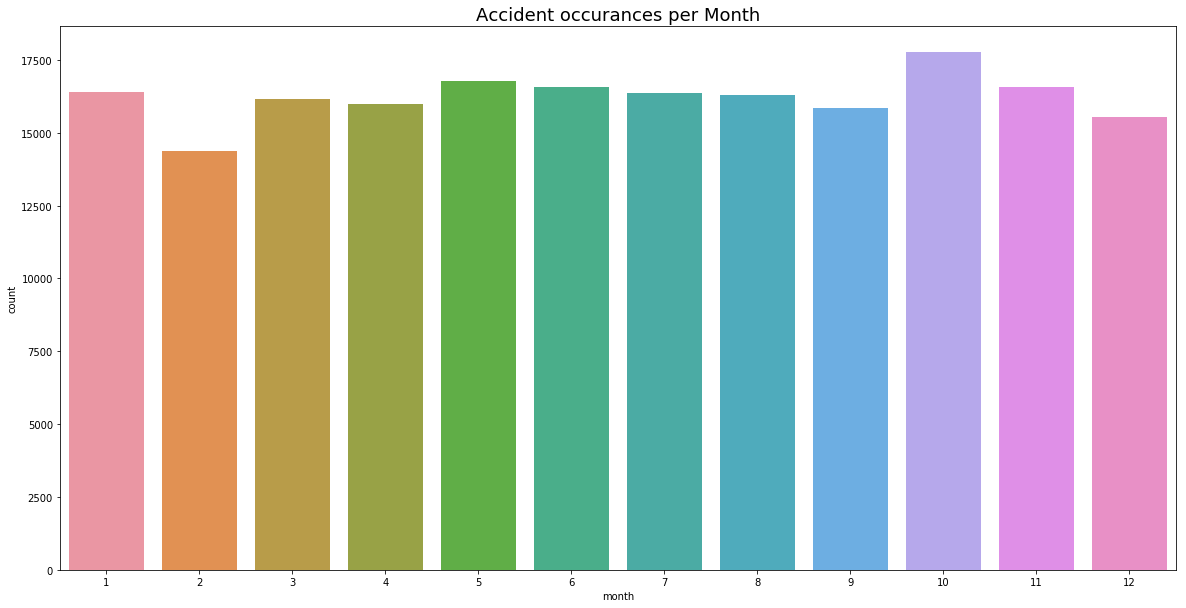

In [13]:
plt.figure(figsize=(20,10))
sns.countplot(x='month', data = analysis)
plt.title('Accident occurances per Month', fontsize=18)
sns.set(style="darkgrid")


Text(0.5, 1.0, 'Accident occurances per Year')

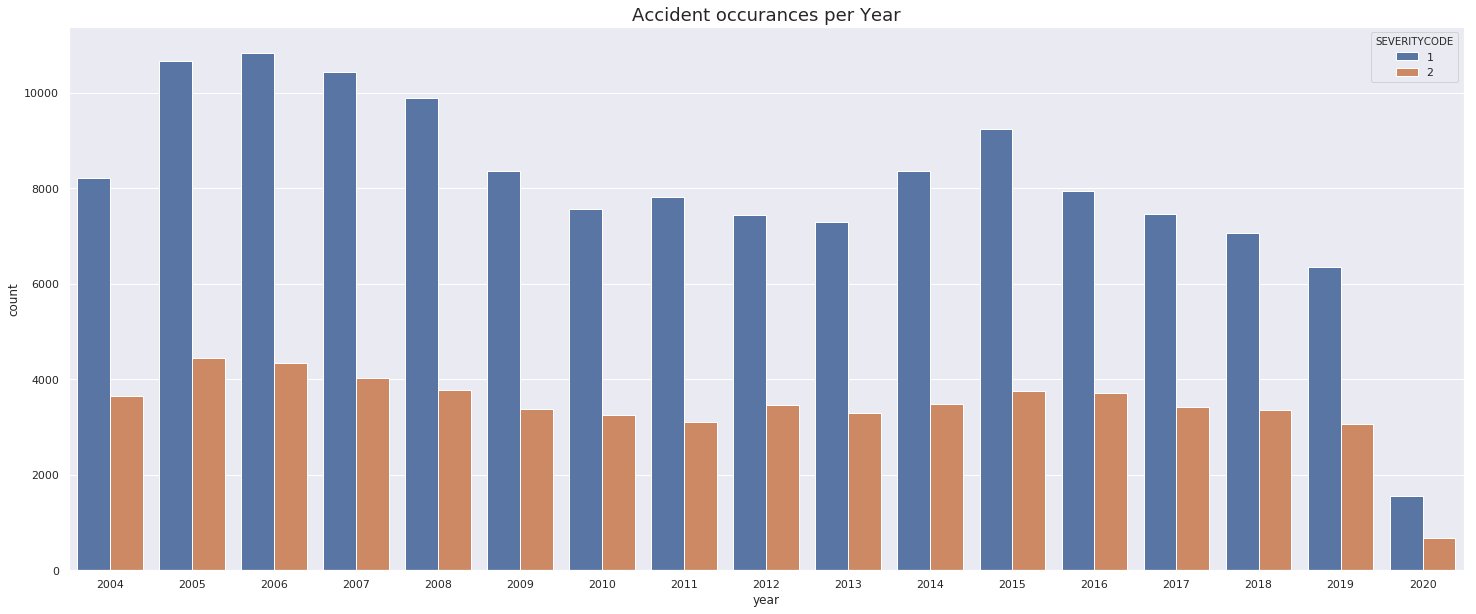

In [14]:
plt.figure(figsize=(25,10))
monthly_accident = sns.countplot(x='year', data = analysis, hue='SEVERITYCODE')
plt.title('Accident occurances per Year', fontsize=18)

Text(0.5, 1.0, 'Accident occurances by Day of Week')

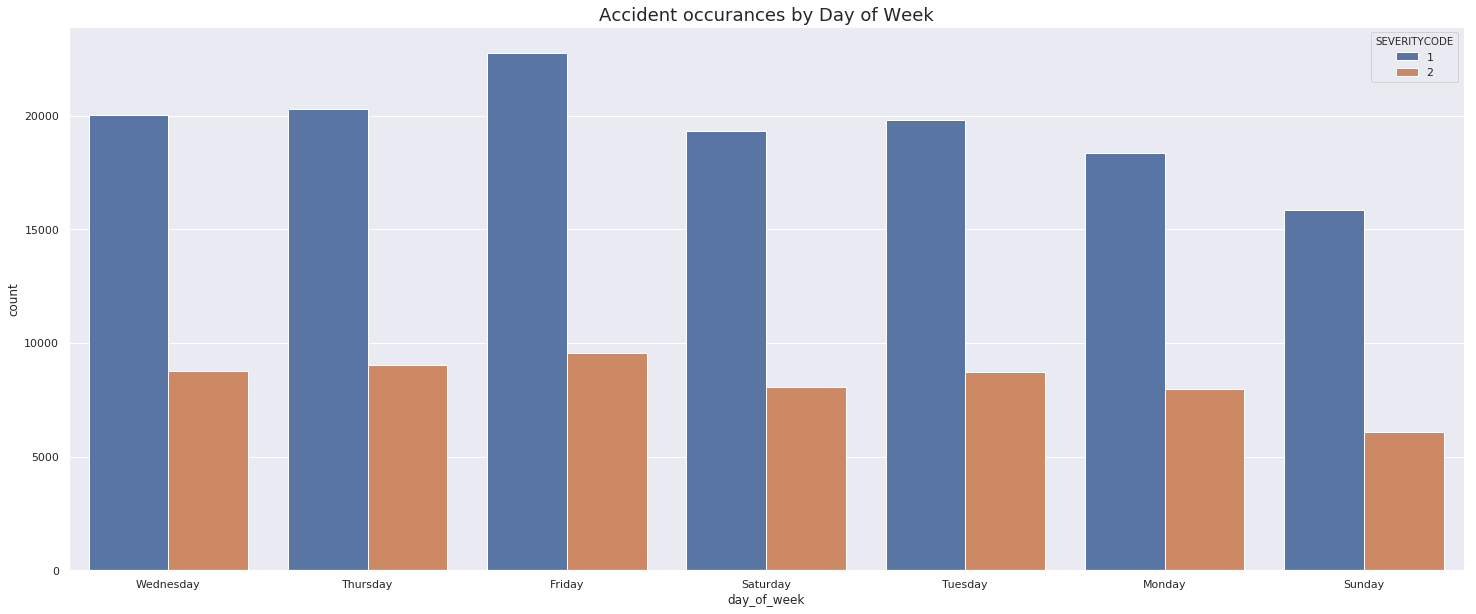

In [15]:
plt.figure(figsize=(25,10))
monthly_accident = sns.countplot(x='day_of_week', data = analysis, hue ='SEVERITYCODE')
plt.title('Accident occurances by Day of Week', fontsize=18)

# Check correlations

# Handle Missing Data

In [16]:
def value_counts(df):
    cols = df.columns
    for col in cols:
        print(df[col].value_counts())

value_counts(df_data)

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64
-122.332653    265
-122.344896    254
-122.328079    252
-122.344997    239
-122.299160    231
-122.351134    212
-122.347294    190
-122.345863    163
-122.332451    160
-122.269988    152
-122.329049    147
-122.310949    146
-122.289923    142
-122.334666    138
-122.339174    136
-122.321920    136
-122.329974    135
-122.335571    133
-122.302329    132
-122.324615    131
-122.269982    130
-122.339439    129
-122.339559    129
-122.316733    128
-122.333757    128
-122.277664    128
-122.323239    126
-122.334792    125
-122.327525    121
-122.287546    121
              ... 
-122.339360      1
-122.350751      1
-122.290428      1
-122.360492      1
-122.346878      1
-122.373860      1
-122.394434      1
-122.291681      1
-122.301697      1
-122.354259      1
-122.386178      1
-122.390046      1
-122.363168      1
-122.349259      1
-122.275380      1
-122.286628      1
-122.280863      1
-122.303664      1
-122.330852 

In [17]:
df_data['COLLISIONTYPE'].value_counts()

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

In [18]:
df_data['COLLISIONTYPE'].replace("Other", np.nan, inplace = True)
df_data['COLLISIONTYPE'].value_counts()


Parked Car    47987
Angles        34674
Rear Ended    34090
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

In [19]:
print(df_data['JUNCTIONTYPE'].isnull().sum())
df_data['JUNCTIONTYPE'].replace('Unknown', np.nan, inplace=True)
print(df_data['JUNCTIONTYPE'].isnull().sum())
df_data['JUNCTIONTYPE'].value_counts()

6329
6338


Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Name: JUNCTIONTYPE, dtype: int64

In [20]:
print(df_data['WEATHER'].isnull().sum())
df_data['WEATHER'].replace('Unknown', np.nan, inplace=True)
df_data['WEATHER'].replace('Other', np.nan, inplace=True)
print(df_data['WEATHER'].isnull().sum())
df_data['WEATHER'].value_counts()

5081
21004


Clear                       111135
Raining                      33145
Overcast                     27714
Snowing                        907
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [21]:
print(df_data['ROADCOND'].isnull().sum())
df_data['ROADCOND'].replace('Unknown', np.nan, inplace=True)
df_data['ROADCOND'].replace('Other', np.nan, inplace=True)
print(df_data['ROADCOND'].isnull().sum())
df_data['ROADCOND'].value_counts()

5012
20222


Dry               124510
Wet                47474
Ice                 1209
Snow/Slush          1004
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [22]:
print(df_data['LIGHTCOND'].isnull().sum())
df_data['LIGHTCOND'].replace('Unknown', np.nan, inplace=True)
df_data['LIGHTCOND'].replace('Other', np.nan, inplace=True)
print(df_data['LIGHTCOND'].isnull().sum())
df_data['LIGHTCOND'].value_counts()

5170
18878


Daylight                    116137
Dark - Street Lights On      48507
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [23]:
# remove date columns
df_data = df_data.drop(["INCDATE",'INCDTTM'],axis=1)

In [24]:
def value_counts(df):
    cols = df.columns
    for col in cols:
        print(df[col].value_counts())

value_counts(df_data)

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64
-122.332653    265
-122.344896    254
-122.328079    252
-122.344997    239
-122.299160    231
-122.351134    212
-122.347294    190
-122.345863    163
-122.332451    160
-122.269988    152
-122.329049    147
-122.310949    146
-122.289923    142
-122.334666    138
-122.339174    136
-122.321920    136
-122.329974    135
-122.335571    133
-122.302329    132
-122.324615    131
-122.269982    130
-122.339439    129
-122.339559    129
-122.316733    128
-122.333757    128
-122.277664    128
-122.323239    126
-122.334792    125
-122.327525    121
-122.287546    121
              ... 
-122.339360      1
-122.350751      1
-122.290428      1
-122.360492      1
-122.346878      1
-122.373860      1
-122.394434      1
-122.291681      1
-122.301697      1
-122.354259      1
-122.386178      1
-122.390046      1
-122.363168      1
-122.349259      1
-122.275380      1
-122.286628      1
-122.280863      1
-122.303664      1
-122.330852 

# Check for unbalanced data in the target

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64


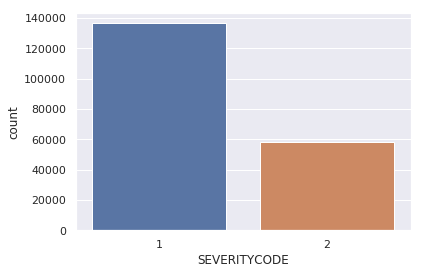

In [25]:
print(df_data['SEVERITYCODE'].value_counts())
sns.countplot(x='SEVERITYCODE', data = df_data)

* Approximately 70% of the target is Severity code one. Will need to balance the data


In [26]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 15 columns):
SEVERITYCODE     194673 non-null int64
X                189339 non-null float64
Y                189339 non-null float64
ADDRTYPE         192747 non-null object
COLLISIONTYPE    166066 non-null object
PERSONCOUNT      194673 non-null int64
PEDCOUNT         194673 non-null int64
PEDCYLCOUNT      194673 non-null int64
VEHCOUNT         194673 non-null int64
JUNCTIONTYPE     188335 non-null object
UNDERINFL        189789 non-null object
WEATHER          173669 non-null object
ROADCOND         174451 non-null object
LIGHTCOND        175795 non-null object
HITPARKEDCAR     194673 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 22.3+ MB


In [27]:
#removing rows for columns with less than 20% values missing (X, Y,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND)

df_data.dropna(subset=["X","Y","COLLISIONTYPE","JUNCTIONTYPE","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND"], 
          axis=0, inplace=True)


In [28]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143747 entries, 0 to 194672
Data columns (total 15 columns):
SEVERITYCODE     143747 non-null int64
X                143747 non-null float64
Y                143747 non-null float64
ADDRTYPE         143747 non-null object
COLLISIONTYPE    143747 non-null object
PERSONCOUNT      143747 non-null int64
PEDCOUNT         143747 non-null int64
PEDCYLCOUNT      143747 non-null int64
VEHCOUNT         143747 non-null int64
JUNCTIONTYPE     143747 non-null object
UNDERINFL        143747 non-null object
WEATHER          143747 non-null object
ROADCOND         143747 non-null object
LIGHTCOND        143747 non-null object
HITPARKEDCAR     143747 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 17.5+ MB


In [29]:

df_data['SEVERITYCODE'].value_counts()

1    94821
2    48926
Name: SEVERITYCODE, dtype: int64

In [30]:
from sklearn.utils import resample

In [31]:
# Separate majority and minority classes
df_severity_1 = df_data[df_data['SEVERITYCODE']==1]
df_severity_2 = df_data[df_data['SEVERITYCODE']==2]
 
# Upsample minority class
df_severity_1_downsample = resample(df_severity_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=48926,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_severity_2, df_severity_1_downsample])
 


#checking if dataset balanced
print(df_balanced.info())
print(df_balanced['SEVERITYCODE'].value_counts())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 97852 entries, 0 to 97668
Data columns (total 15 columns):
SEVERITYCODE     97852 non-null int64
X                97852 non-null float64
Y                97852 non-null float64
ADDRTYPE         97852 non-null object
COLLISIONTYPE    97852 non-null object
PERSONCOUNT      97852 non-null int64
PEDCOUNT         97852 non-null int64
PEDCYLCOUNT      97852 non-null int64
VEHCOUNT         97852 non-null int64
JUNCTIONTYPE     97852 non-null object
UNDERINFL        97852 non-null object
WEATHER          97852 non-null object
ROADCOND         97852 non-null object
LIGHTCOND        97852 non-null object
HITPARKEDCAR     97852 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 11.9+ MB
None
2    48926
1    48926
Name: SEVERITYCODE, dtype: int64


# Encode categorical columns and split in test and train

In [32]:
X = df_balanced.loc[:,df_balanced.columns != "SEVERITYCODE"] 

#Encoding Categorical Features - Training Dataset
X = pd.get_dummies(data=X, columns=['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER',
                                                            'ROADCOND','LIGHTCOND','UNDERINFL','HITPARKEDCAR'])

Y = df_balanced[['SEVERITYCODE']]
print(X.info())
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97852 entries, 0 to 97668
Data columns (total 50 columns):
X                                                                 97852 non-null float64
Y                                                                 97852 non-null float64
PERSONCOUNT                                                       97852 non-null int64
PEDCOUNT                                                          97852 non-null int64
PEDCYLCOUNT                                                       97852 non-null int64
VEHCOUNT                                                          97852 non-null int64
ADDRTYPE_Block                                                    97852 non-null uint8
ADDRTYPE_Intersection                                             97852 non-null uint8
COLLISIONTYPE_Angles                                              97852 non-null uint8
COLLISIONTYPE_Cycles                                              97852 non-null uint8
COLLISIONTYPE_Hea

# Scale Train and Test data

In [33]:
scaler = StandardScaler()
X_train[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']] = scaler.fit_transform(
    X_train[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']])

scaler = StandardScaler()
X_test[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']] = scaler.fit_transform(
    X_test[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']])

X_train.info()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78281 entries, 11095 to 2330
Data columns (total 50 columns):
X                                                                 78281 non-null float64
Y                                                                 78281 non-null float64
PERSONCOUNT                                                       78281 non-null float64
PEDCOUNT                                                          78281 non-null float64
PEDCYLCOUNT                                                       78281 non-null float64
VEHCOUNT                                                          78281 non-null float64
ADDRTYPE_Block                                                    78281 non-null uint8
ADDRTYPE_Intersection                                             78281 non-null uint8
COLLISIONTYPE_Angles                                              78281 non-null uint8
COLLISIONTYPE_Cycles                                              78281 non-null uint8
COLLIS

# Logistic Regression

In [34]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)

#Confusion Matrix
conf_matx = confusion_matrix(Y_test,lr_pred)
print(conf_matx)

#Classification Report
cl_report = classification_report(Y_test,lr_pred)
print(cl_report,'\n')

#Accuracy
acc = accuracy_score(Y_test,lr_pred)
print(acc,'\n')

# Create a dictionary to store the accuracy scores for each of the classification algorithms for later use
acc_dict = {}
acc_dict['LR'] = acc

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[5407 4361]
 [1570 8233]]
              precision    recall  f1-score   support

           1       0.77      0.55      0.65      9768
           2       0.65      0.84      0.74      9803

   micro avg       0.70      0.70      0.70     19571
   macro avg       0.71      0.70      0.69     19571
weighted avg       0.71      0.70      0.69     19571
 

0.6969495682387206 



# KNN Classifier

In [36]:
# get the values for X and Y for use in Knn Classifer which accepts a series
Xknn = X
Yknn = Y.values.ravel() # need to flatten to 1dArray for KNeighborsClassifier

Xknn_train, Xknn_test, Yknn_train, Yknn_test = train_test_split( Xknn, Yknn, test_size=0.2, random_state=42)
print ('Train set:', Xknn_train.shape,  Yknn_train.shape)
print ('Test set:', Xknn_test.shape,  Yknn_test.shape)


Train set: (78281, 50) (78281,)
Test set: (19571, 50) (19571,)


In [37]:
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(Xknn_train,Yknn_train)
# yhat=neigh.predict(Xknn_test)
yhat=neigh.predict(Xknn_test)

In [38]:
knn_acc = accuracy_score(Yknn_test, yhat)
print(knn_acc)
acc_dict['KNN'] = knn_acc

0.6843288539165091


In [52]:
# find the nost accurate k from 5 to 10

# issues with the Kernel timing out

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(5,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(Xknn_train,Yknn_train)
    yhat=neigh.predict(Xknn_test)
    mean_acc[n-1] = accuracy_score(Yknn_test, yhat)

    
#     std_acc[n-1]=np.std(yhat==Yknn_test)/np.sqrt(yhat.shape[0])

mean_acc

KeyboardInterrupt: 

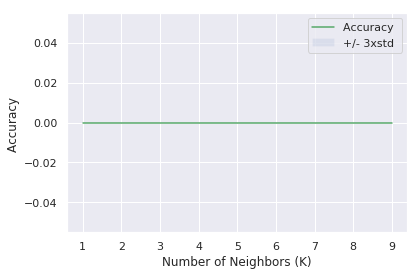

In [53]:
#issue with above timing out

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Decision Tree 

In [39]:
tree = DecisionTreeClassifier(criterion ='entropy', max_depth=5)
tree.fit(X_train, Y_train)
tree_pred = tree.predict(X_test)
tree_acc = accuracy_score(Y_test, tree_pred)

acc_dict['DT'] = tree_acc

In [40]:
rf = RandomForestClassifier()
params = {'n_estimators':[50,75,100],
          'criterion':['gini', 'entropy'], 
          'random_state':[0]}
rf1 = GridSearchCV(rf, param_grid=params)
rf1.fit(X_train,Y_train.values.ravel())
rf_predictions = rf1.predict(X_test)
print('Best Hyperparameter RFT : ',rf1.best_params_)

#Confusion Matrix
rf_cm=confusion_matrix(Y_test,rf_predictions)
print(rf_cm,'\n')

#Classification Report
rf_cr = classification_report(Y_test,rf_predictions)
print(rf_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,rf_predictions)
print(acc,'\n')
acc_dict['RFT'] = acc

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyperparameter RFT :  {'criterion': 'entropy', 'n_estimators': 75, 'random_state': 0}
[[7068 2700]
 [2842 6961]] 

              precision    recall  f1-score   support

           1       0.71      0.72      0.72      9768
           2       0.72      0.71      0.72      9803

   micro avg       0.72      0.72      0.72     19571
   macro avg       0.72      0.72      0.72     19571
weighted avg       0.72      0.72      0.72     19571
 

0.7168259158959686 



# SVM

In [35]:
print(Y_train.values.ravel().shape)
print(X_train.shape)

(78281,)
(78281, 50)


In [42]:
svm = SVC(kernel='linear')
svm.fit(X_train, Y_train.values.ravel())
svm_predict= svm.predict(X_test)

In [44]:
#Confusion Matrix
svc_cm=confusion_matrix(Y_test,svm_predict)
print(svc_cm,'\n')

#Classification Report
svc_cr = classification_report(Y_test,svm_predict)
print(svc_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,svm_predict)
print(acc,'\n')
acc_dict['SVC'] = acc

[[4833 4935]
 [1045 8758]] 

              precision    recall  f1-score   support

           1       0.82      0.49      0.62      9768
           2       0.64      0.89      0.75      9803

   micro avg       0.69      0.69      0.69     19571
   macro avg       0.73      0.69      0.68     19571
weighted avg       0.73      0.69      0.68     19571
 

0.694445863778039 



In [45]:
lists = sorted(acc_dict.items()) # sorted by key, return a list of tuples

classifier, accuracy = zip(*lists) # unpack a list of pairs into two tuples

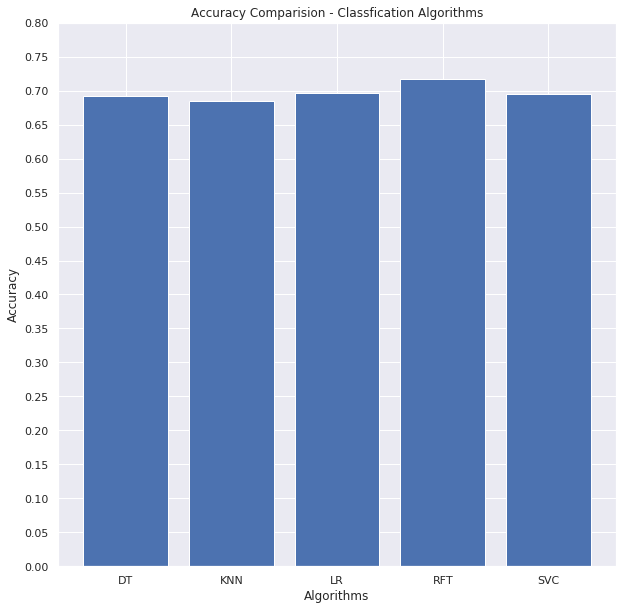

In [46]:
plt.figure(figsize=(10,10))
plt.bar(classifier, accuracy)
plt.xlabel('Algorithms')
plt.yticks(np.arange(0,max(accuracy)+0.1,0.05))
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision - Classfication Algorithms')
plt.show()